<a href="https://colab.research.google.com/github/ramchangalva/Ram_Project/blob/master/Copy_of_Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Demo Full Pipeline



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Directory to store the model and results

In [2]:
import os
%cd /content/
%mkdir AVLPR

/content


# Download Pre trained model from google "Automl"

In [3]:
if not os.path.isdir("automl"):
    # clone the repository
    !git clone --depth 1 https://github.com/google/automl
        
    # checkout to the latest commit that we used when we're creating this notebook
    %cd automl
    !git checkout 1ec78d22aa9f8b7d33b9cf3a177e05dcc6b4a093
    
    # change the working directory
    %cd efficientdet
    
    # install required packages
    # if it fails to install pycocotools, please manually remove pycocotools from requirements.txt and run again
    %pip install -r requirements.txt
    %pip install -U "git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI"

PROJ_DIR = os.path.join("..", "..")

Cloning into 'automl'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 153 (delta 17), reused 45 (delta 0), pack-reused 0
Receiving objects: 100% (153/153), 11.47 MiB | 3.76 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/automl
fatal: reference is not a tree: 1ec78d22aa9f8b7d33b9cf3a177e05dcc6b4a093
/content/automl/efficientdet
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-flxi2fg4
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-flxi2fg4
     |████████████████████████████████| 6.3MB 15.9MB/s 
     |████████████████████████████████| 645kB 46.4MB/s 
     |████████████████████████████████| 686kB 27.9MB/s 
     |████████████████████████████████| 122kB 57.7MB/s 
     |████████████████████████████████| 215kB 56.1MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.wh

In [4]:
MODEL = "efficientdet-d1"
if not os.path.exists(f"{MODEL}.tar.gz"):
    !curl -O https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco2/{MODEL}.tar.gz
    !tar xvzf {MODEL}.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46.5M  100 46.5M    0     0  35.7M      0  0:00:01  0:00:01 --:--:-- 35.7M
efficientdet-d1/
efficientdet-d1/model.meta
efficientdet-d1/model.index
efficientdet-d1/checkpoint
efficientdet-d1/d1_coco_val.txt
efficientdet-d1/d1_coco_test-dev2017.txt
efficientdet-d1/model.data-00000-of-00001


# CCPD dataset from Google drive to Google Colab pro drive

In [5]:
%cd /content/drive/MyDrive/LicensePlate/
import shutil
def main():
    # Copy file to another directory
    newPath = shutil.copy('/content/drive/MyDrive/LicensePlate/CCPD2019.tar', '/content/AVLPR/')
    print("Path of copied file : ", newPath)
    
if __name__ == '__main__':
    main()

/content/drive/MyDrive/LicensePlate
Path of copied file :  /content/AVLPR/CCPD2019.tar


# Unzip the source image dataset

In [6]:
# CCPD Dataset Folder
%cd /content/AVLPR/
dsetname = "CCPD2019.tar"
!tar xf {dsetname}
!rm {dsetname}
# Removing the Test data due to space constraints
!rm -rf CCPD2019/ccpd_blur CCPD2019/ccpd_challenge CCPD2019/ccpd_db CCPD2019/ccpd_fn CCPD2019/ccpd_np CCPD2019/ccpd_rotate CCPD2019/ccpd_tilt CCPD2019/ccpd_weather

/content/AVLPR


# Generate Annotation and TF Records


In [7]:

PROJ_DIR = '/content/AVLPR/'
DATASET_DIR = os.path.join(PROJ_DIR, "CCPD2019")
TFRECORD_DIR = os.path.join(PROJ_DIR, "tfrecords")

TRAIN_SET_FILE = os.path.join(DATASET_DIR, "splits", "train.txt")
VAL_SET_FILE = os.path.join(DATASET_DIR, "splits", "val.txt")
TEST_SET_FILE = os.path.join(DATASET_DIR, "splits", "test.txt")

SAMPLES_PER_FILE = 10000   # we only construct a subset, in total there are 100,000 samples in each set

LP_CLASS = 1   # class id for the license plate

In [8]:
import re
import hashlib

import PIL.Image
import tensorflow as tf
from tensorflow.compat.v1.python_io import tf_record_iterator


def filename_to_annotation(filename):
    """
    Annotations are embedded in file name.

    A sample image name is "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg". Each name can be splited into seven fields. Those fields are explained as follows.

        Area: Area ratio of license plate area to the entire picture area.

        Tilt degree: Horizontal tilt degree and vertical tilt degree.

        Bounding box coordinates: The coordinates of the left-up and the right-bottom vertices.

        Four vertices locations: The exact (x, y) coordinates of the four vertices of LP in the whole image. These coordinates start from the right-bottom vertex.

        License plate number: Each image in CCPD has only one LP. Each LP number is comprised of a Chinese character, a letter, and five letters or numbers. A valid Chinese license plate consists of seven characters: province (1 character), alphabets (1 character), alphabets+digits (5 characters). "0_0_22_27_27_33_16" is the index of each character. These three arrays are defined as follows. The last character of each array is letter O rather than a digit 0. We use O as a sign of "no character" because there is no O in Chinese license plate characters.

        Brightness: The brightness of the license plate region.

        Blurriness: The Blurriness of the license plate region.
    """

    a = re.match(
        r'^'
        r'([0-9]+)-'
        r'([0-9]+)_([0-9]+)-'
        r'([0-9]+)&([0-9]+)_([0-9]+)&([0-9]+)-'
        r'([0-9]+)&([0-9]+)_([0-9]+)&([0-9]+)_([0-9]+)&([0-9]+)_([0-9]+)&([0-9]+)-'
        r'([0-9_]+)-'
        r'([0-9]+)-'
        r'([0-9]+)'
        r'.jpg$'
        , filename
    )

    if a:
        a = a.groups()
        anno = {
            "area_ratio": int(a[0]),
            "tilt_h": int(a[1]),
            "tile_v": int(a[2]),
            "bbox": {
                "left": int(a[3]),
                "top": int(a[4]),
                "right": int(a[5]),
                "bottom": int(a[6])
            },
            "lp": str(a[15]),
            "brightness": int(a[16]),
            "blurriness": int(a[17])
        }
        assert anno["bbox"]["left"] < anno["bbox"]["right"]
        assert anno["bbox"]["top"] < anno["bbox"]["bottom"]
    else:
        raise ValueError("the filename cannot be resolved")

    return anno


def create_example(id, filepath, annotation):
    img_raw = open(filepath, "rb").read()
    key = hashlib.sha256(img_raw).hexdigest()
    filename = os.path.basename(filepath)
    width, height = PIL.Image.open(filepath).size

    example = tf.train.Example(features=tf.train.Features(feature={
        "image/height": tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        "image/width": tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        "image/filename": tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode("utf-8")])),
        "image/source_id": tf.train.Feature(bytes_list=tf.train.BytesList(value=[str(id).encode("utf-8")])),
        "image/key/sha256": tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode("utf-8")])),
        "image/encoded": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        "image/format": tf.train.Feature(bytes_list=tf.train.BytesList(value=["jpg".encode("utf8")])),
        "image/object/bbox/xmin": tf.train.Feature(float_list=tf.train.FloatList(value=[annotation["bbox"]["left"] / width])),
        "image/object/bbox/xmax": tf.train.Feature(float_list=tf.train.FloatList(value=[annotation["bbox"]["right"] / width])),
        "image/object/bbox/ymin": tf.train.Feature(float_list=tf.train.FloatList(value=[annotation["bbox"]["top"] / height])),
        "image/object/bbox/ymax": tf.train.Feature(float_list=tf.train.FloatList(value=[annotation["bbox"]["bottom"] / height])),
        "image/object/class/text": tf.train.Feature(bytes_list=tf.train.BytesList(value=["license_plate".encode("utf-8")])),
        "image/object/class/label": tf.train.Feature(int64_list=tf.train.Int64List(value=[LP_CLASS])),
        "image/object/difficult": tf.train.Feature(int64_list=tf.train.Int64List(value=[0])),
        "image/object/truncated": tf.train.Feature(int64_list=tf.train.Int64List(value=[0])),
        "image/object/view": tf.train.Feature(bytes_list=tf.train.BytesList(value=["Unspecified".encode("utf-8")])),
    }))
    return example


def create_tfrecord(dataset_path, output_path, samples_per_file):
    print(f"creating {dataset_path} at {output_path}")

    # create the output directory if not exist
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # read the dataset
    with open(dataset_path, "r") as fread:
        lines = fread.read().splitlines()

    # write examples into tfrecord
    fid = 0
    partition_path = output_path + f"-{fid:02d}"
    tfwriter = tf.io.TFRecordWriter(partition_path)
    for i, subpath in enumerate(lines):
        if (i + 1) % samples_per_file == 0:
            fid += 1
            partition_path = output_path + f"-{fid:02d}"
            tfwriter.close()
            tfwriter = tf.io.TFRecordWriter(partition_path)

        filepath = os.path.join(DATASET_DIR, subpath)
        filename = os.path.basename(filepath)
        annotation = filename_to_annotation(filename)
        example = create_example(i + 1, filepath, annotation)
        tfwriter.write(example.SerializeToString())
    tfwriter.close()

# Generate TfRecords for Tain and validation set

In [9]:
create_tfrecord(TRAIN_SET_FILE, os.path.join(TFRECORD_DIR, "train.tfrecord"), SAMPLES_PER_FILE)
create_tfrecord(VAL_SET_FILE, os.path.join(TFRECORD_DIR, "val.tfrecord"), SAMPLES_PER_FILE)
#create_tfrecord(TEST_SET_FILE, os.path.join(TFRECORD_DIR, "test.tfrecord"), SAMPLES_PER_FILE)

creating /content/AVLPR/CCPD2019/splits/train.txt at /content/AVLPR/tfrecords/train.tfrecord
creating /content/AVLPR/CCPD2019/splits/val.txt at /content/AVLPR/tfrecords/val.tfrecord


# Genearate config yaml file

In [10]:
PROJ_DIR = '/content/AVLPR/'
CONFIG_DIR = os.path.join(PROJ_DIR, "configs")
CONFIG_FILE = os.path.join(CONFIG_DIR, "default.yaml")
if not os.path.exists(CONFIG_DIR):
    os.mkdir(CONFIG_DIR)

config_text = \
"""image_size: 1024x1024
num_classes: 1
label_map: {1: license_plate}
input_rand_hflip: true
jitter_min: 0.8
jitter_max: 1.2
"""

with open(CONFIG_FILE, "w") as fwrite:
    fwrite.write(config_text)

# Model parameters

In [20]:
CKPT = MODEL

TRAIN_SET = os.path.join(TFRECORD_DIR, "train.tfrecord-*")
VAL_SET = os.path.join(TFRECORD_DIR, "val.tfrecord-*")
MODEL_DIR_TMP = os.path.join(PROJ_DIR, "tmp", f"{MODEL}-finetune")
TRAIN_NUM_EXAMPLES = 5000
EVAL_NUM_EXAMPLES = 5000
EPOCHS = 1
BATCH_SIZE = 2
print(MODEL)

efficientdet-d1


# Training the model

In [22]:
%cd  /content/automl/efficientdet/
!python -m main \
    --mode=train_and_eval \
    --train_file_pattern={TRAIN_SET} \
    --val_file_pattern={VAL_SET} \
    --model_name={MODEL} \
    --model_dir={MODEL_DIR_TMP} \
    --ckpt={CKPT} \
    --train_batch_size={BATCH_SIZE} \
    --eval_batch_size={BATCH_SIZE} \
    --num_epochs={EPOCHS} \
    --num_examples_per_epoch={TRAIN_NUM_EXAMPLES} \
    --eval_samples={EVAL_NUM_EXAMPLES} \
    --hparams={CONFIG_FILE}

/content/automl/efficientdet
2021-07-03 21:58:41.479751: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
I0703 21:58:43.023084 140603764025216 main.py:228] {'name': 'efficientdet-d1', 'act_type': 'swish', 'image_size': (1024, 1024), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.8, 'jitter_max': 1.2, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'map_freq': 5, 'num_classes': 1, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': {1: 'license_plate'}, 'max_instances_per_image': 100, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 4.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power': 0.9, 'c

## inference of the model

In [23]:
MODEL_DIR_EXPORT = os.path.join(PROJ_DIR, "models", f"{MODEL}-finetune")

MIN_SCORE_THRESHOLD = 0.1

!python -m model_inspect \
    --runmode=saved_model \
    --model_name={MODEL} \
    --ckpt_path={MODEL_DIR_TMP} \
    --saved_model_dir={MODEL_DIR_EXPORT} \
    --min_score_thresh={MIN_SCORE_THRESHOLD} \
    --hparams={CONFIG_FILE}

2021-07-03 22:43:50.392665: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-03 22:43:52.134487: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-03 22:43:52.140529: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-03 22:43:52.162406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-03 22:43:52.163111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla

# Store the results from the model

In [24]:
TEST_IMAGE_DIR = os.path.join(DATASET_DIR, "ccpd_base")
TEST_IMAGE_FILES = os.path.join(TEST_IMAGE_DIR, "*.jpg")
#TEST_IMAGE_FILES = os.path.join(TEST_IMAGE_DIR, "09-1_13-81&477_603&621-578&604_81&621_106&494_603&477-0_0_24_31_3_27_30-102-134.jpg")

RESULT_DIR = os.path.join(PROJ_DIR, "results")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

# we can set a higher threshold here
# however, the results are already filtered with the previous threshold during the model exporting
MIN_SCORE_THRESHOLD = 0.5

!python -m model_inspect \
    --runmode=saved_model_infer \
    --saved_model_dir={MODEL_DIR_EXPORT} \
    --model_name={MODEL} \
    --input_image={TEST_IMAGE_FILES} \
    --output_image_dir={RESULT_DIR} \
    --min_score_thresh={MIN_SCORE_THRESHOLD} \
    --hparams={CONFIG_FILE}

2021-07-03 22:48:00.360512: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-03 22:48:02.042204: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-03 22:48:02.043331: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-03 22:48:02.056624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-03 22:48:02.057221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
writing file to /content/AVLPR/results/85312.jpg
writing file to /content/AVLPR/results/85313.jpg
writing file to /content/AVLPR/results/85314.jpg
writing file to /content/AVLPR/results/85315.jpg
writing file to /content/AVLPR/results/85316.jpg
writing file to /content/AVLPR/results/85317.jpg
writing file to /content/AVLPR/results/85318.jpg
writing file to /content/AVLPR/results/85319.jpg
writing file to /content/AVLPR/results/85320.jpg
writing file to /content/AVLPR/results/85321.jpg
writing file to /content/AVLPR/results/85322.jpg
writing file to /content/AVLPR/results/85323.jpg
writing file to /content/AVLPR/results/85324.jpg
writing file to /content/AVLPR/results/85325.jpg
writing file to /content/AVLPR/results/85326.jpg
writing file to /content/AVLPR/results/85327.jpg
writing file to /content/AVLPR/results/85328.jpg
writing file to /content/AVLPR/results/85329.jpg
writing file to /content/AVLPR/results/85330.jpg
writing file to /c

# Inspect the License Plate detection Accuracy

/content/AVLPR/results/0.jpg


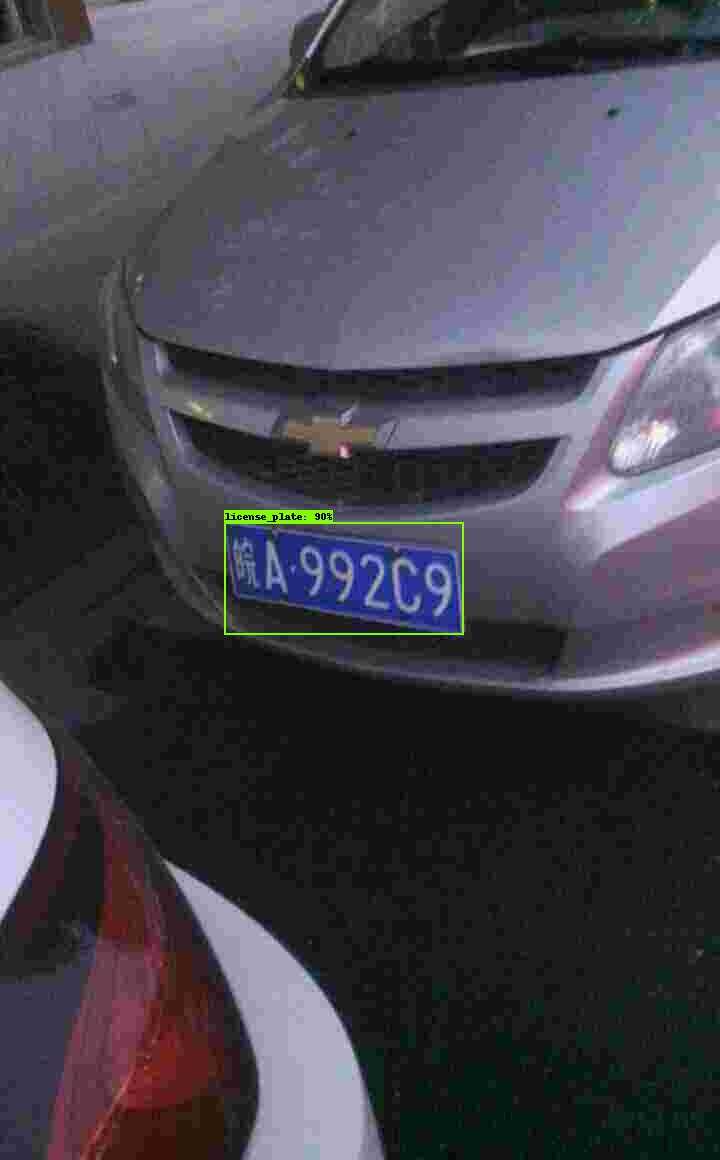

/content/AVLPR/results/1.jpg


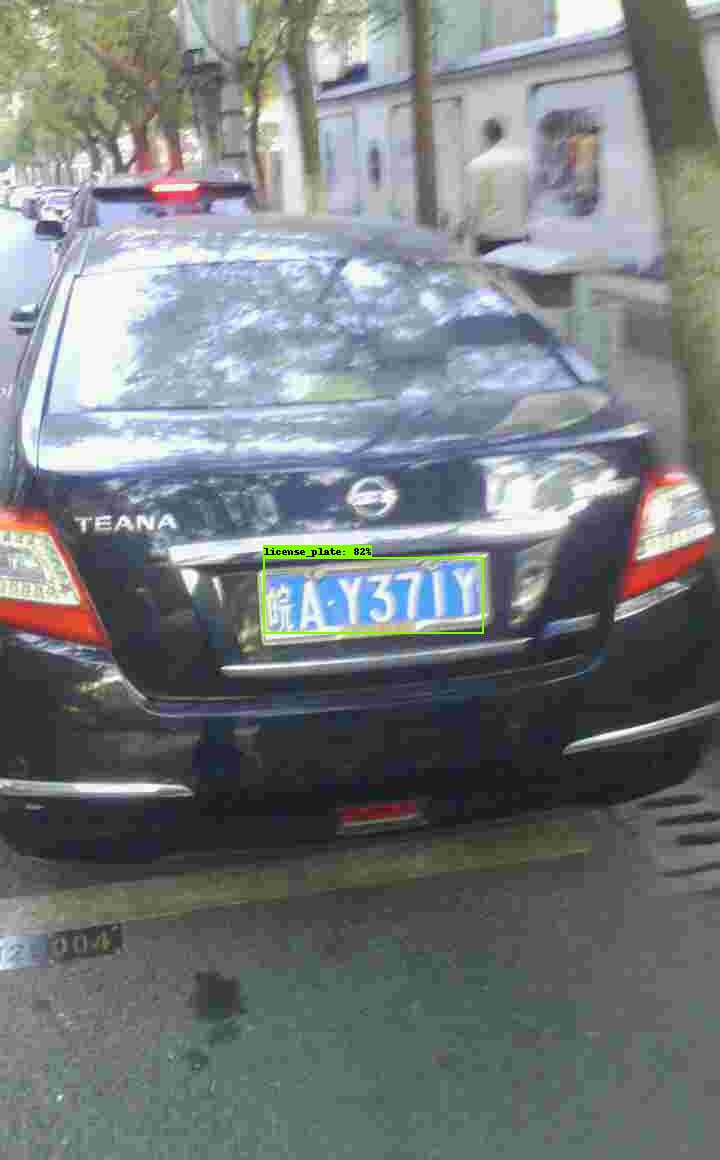

/content/AVLPR/results/2.jpg


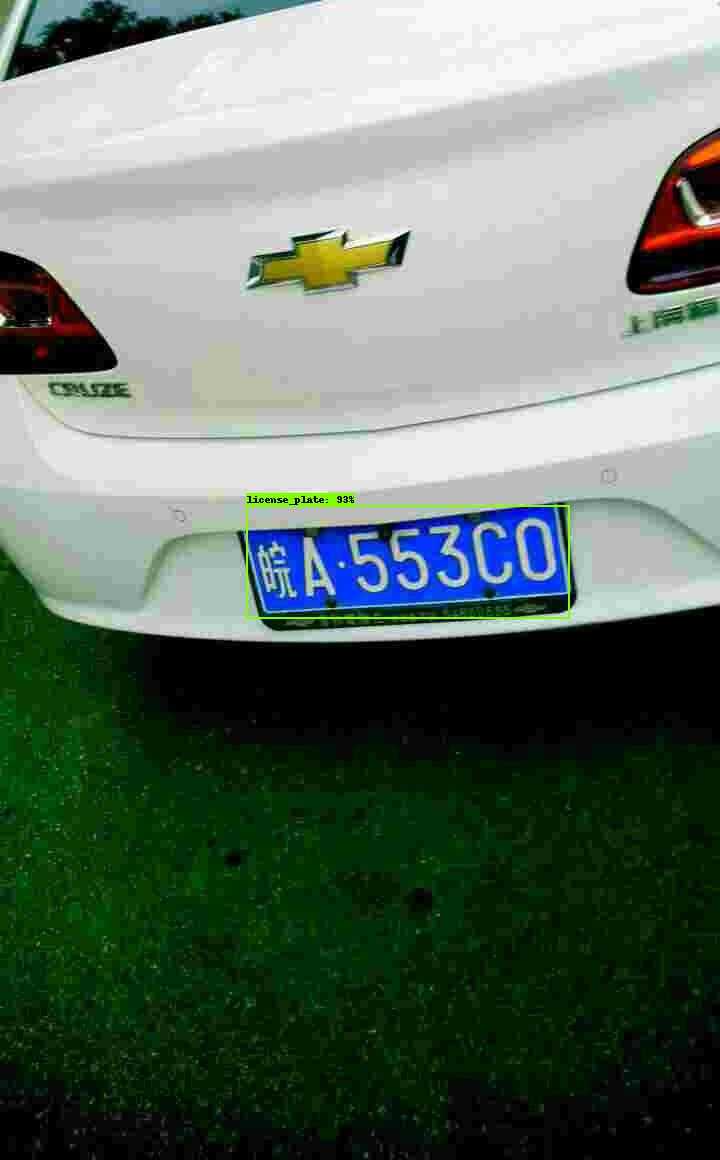

/content/AVLPR/results/3.jpg


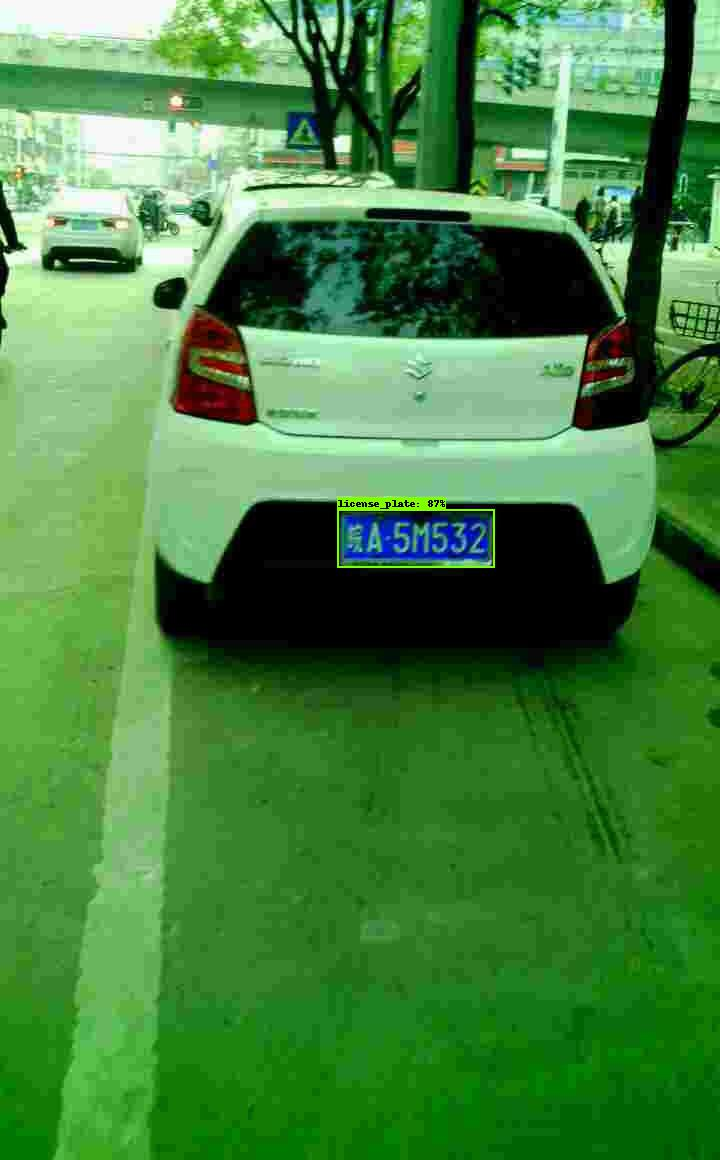

/content/AVLPR/results/4.jpg


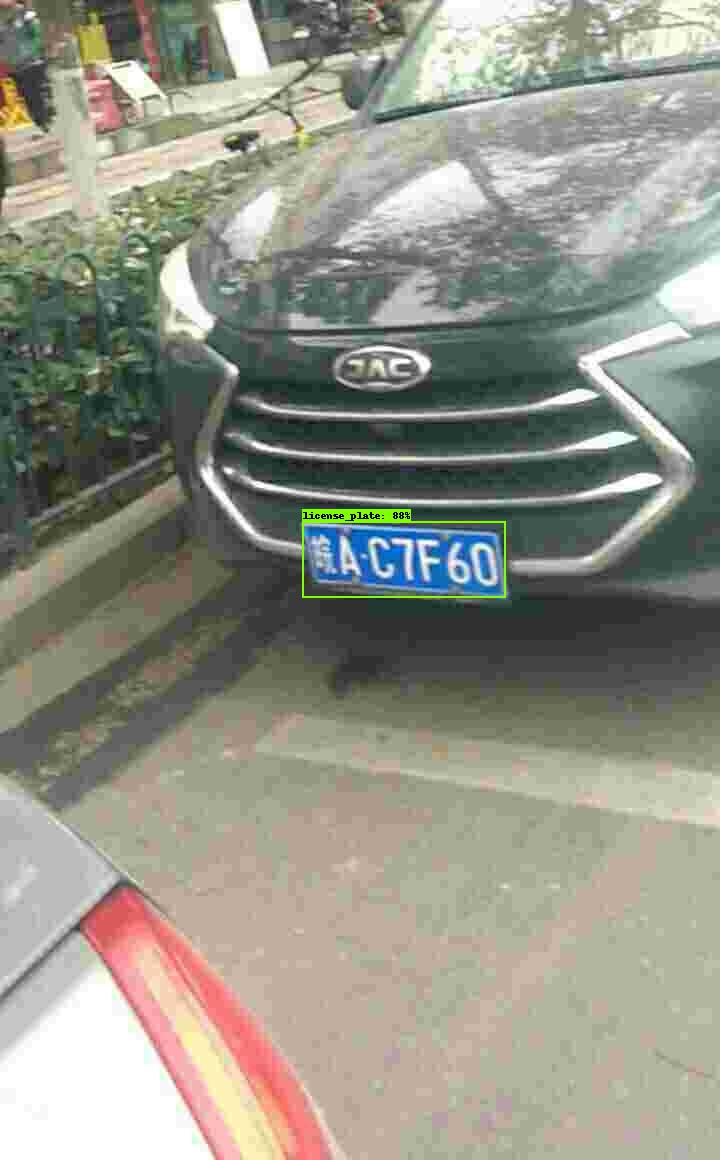

/content/AVLPR/results/5.jpg


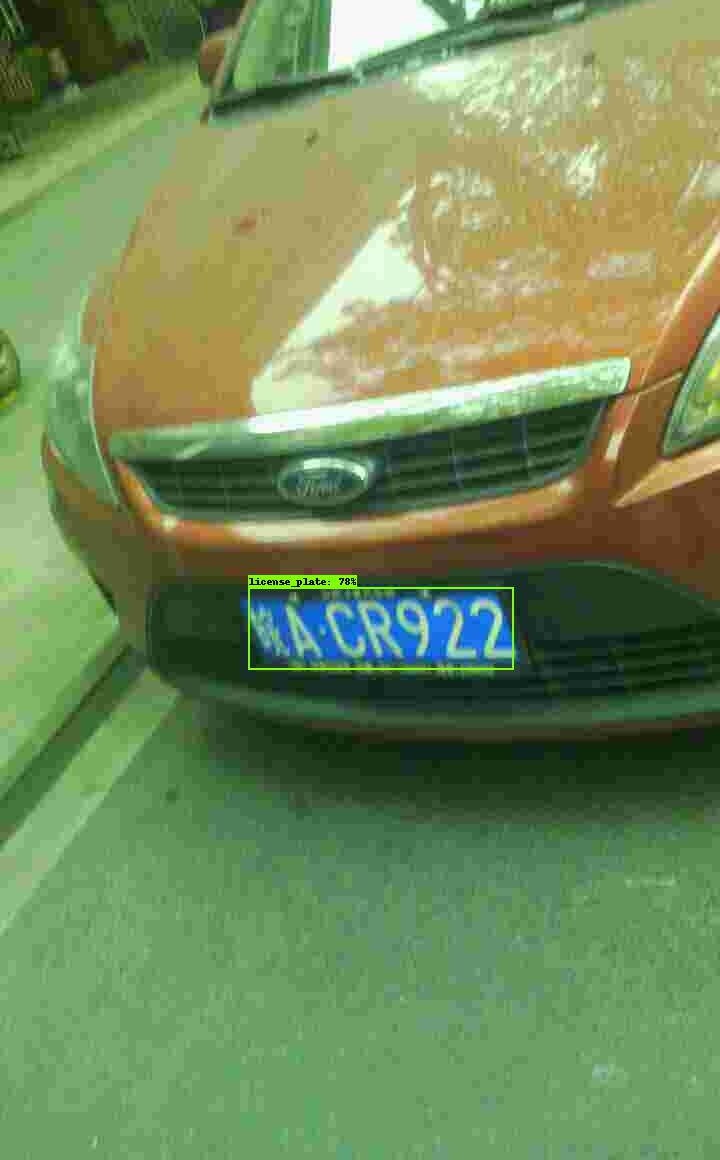

/content/AVLPR/results/6.jpg


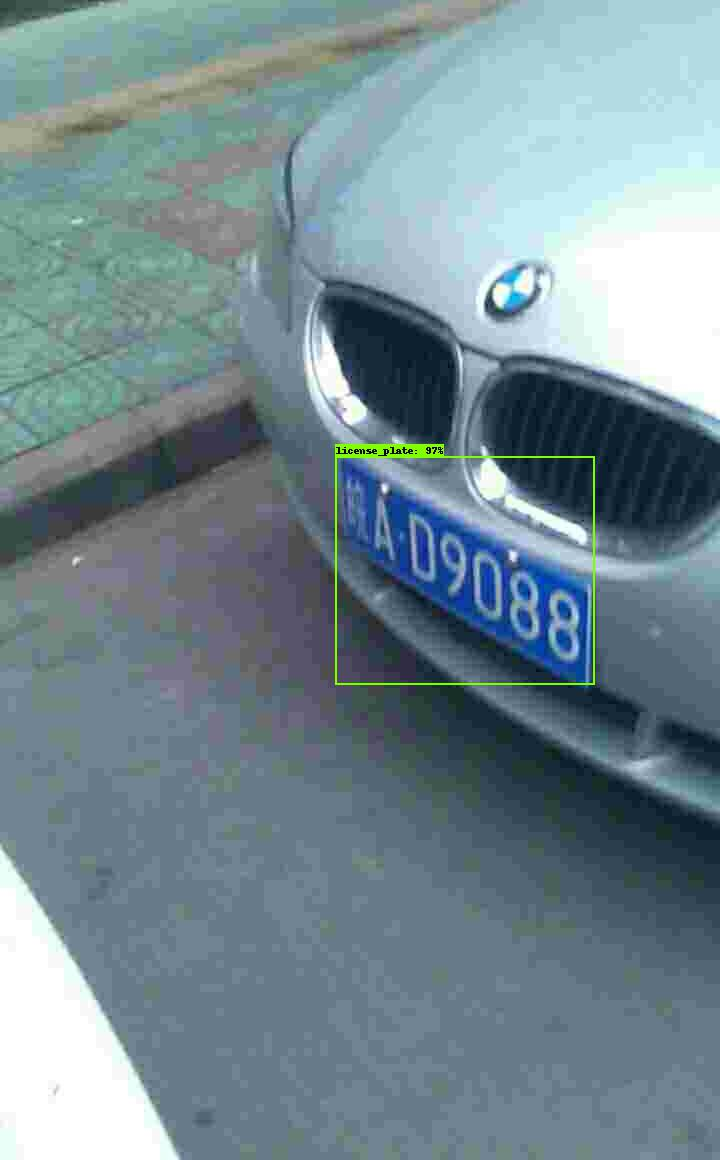

/content/AVLPR/results/7.jpg


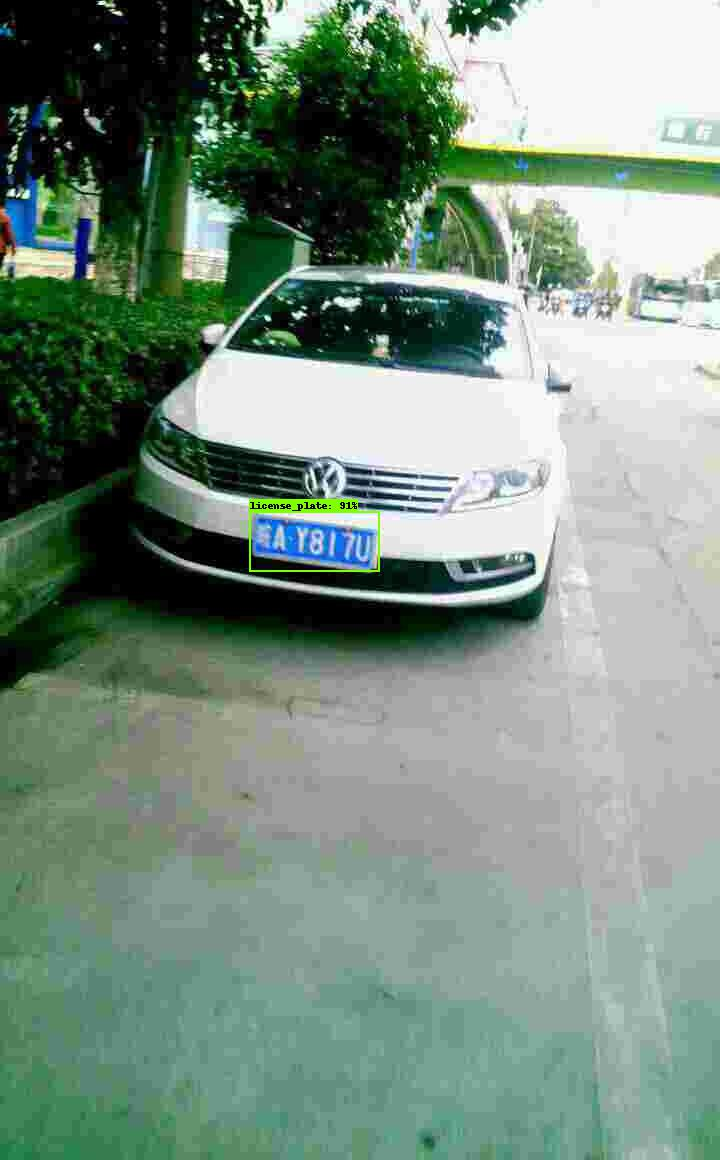

/content/AVLPR/results/8.jpg


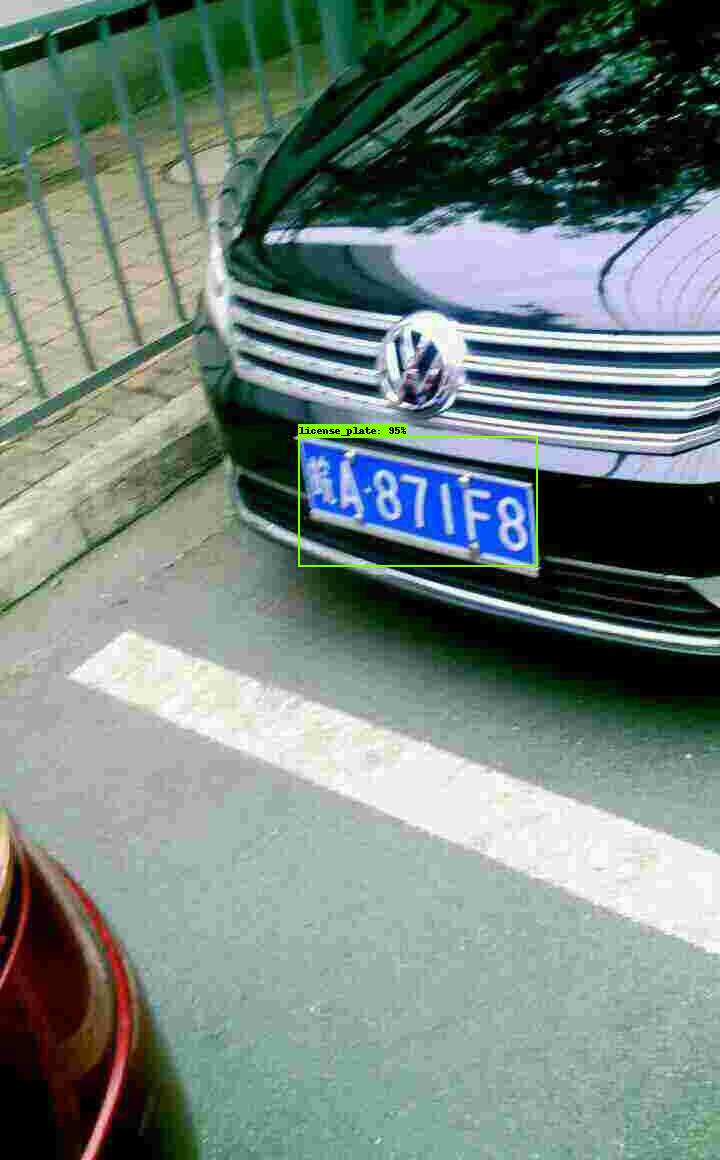

/content/AVLPR/results/9.jpg


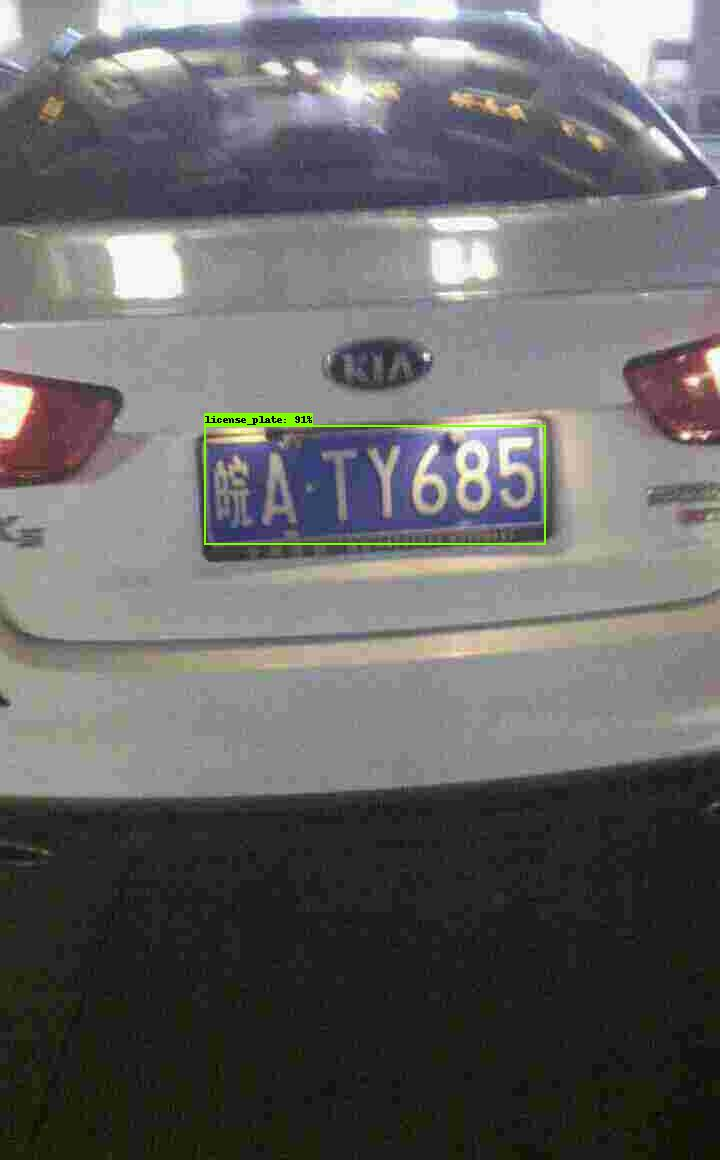

/content/AVLPR/results/10.jpg


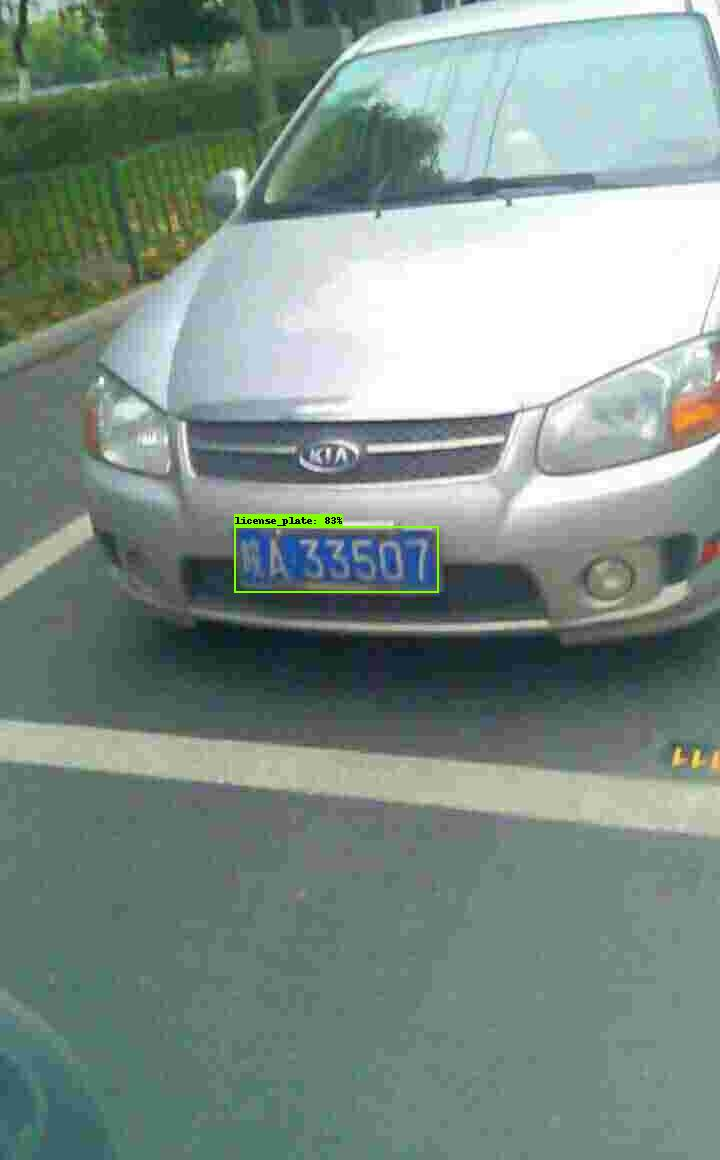

/content/AVLPR/results/11.jpg


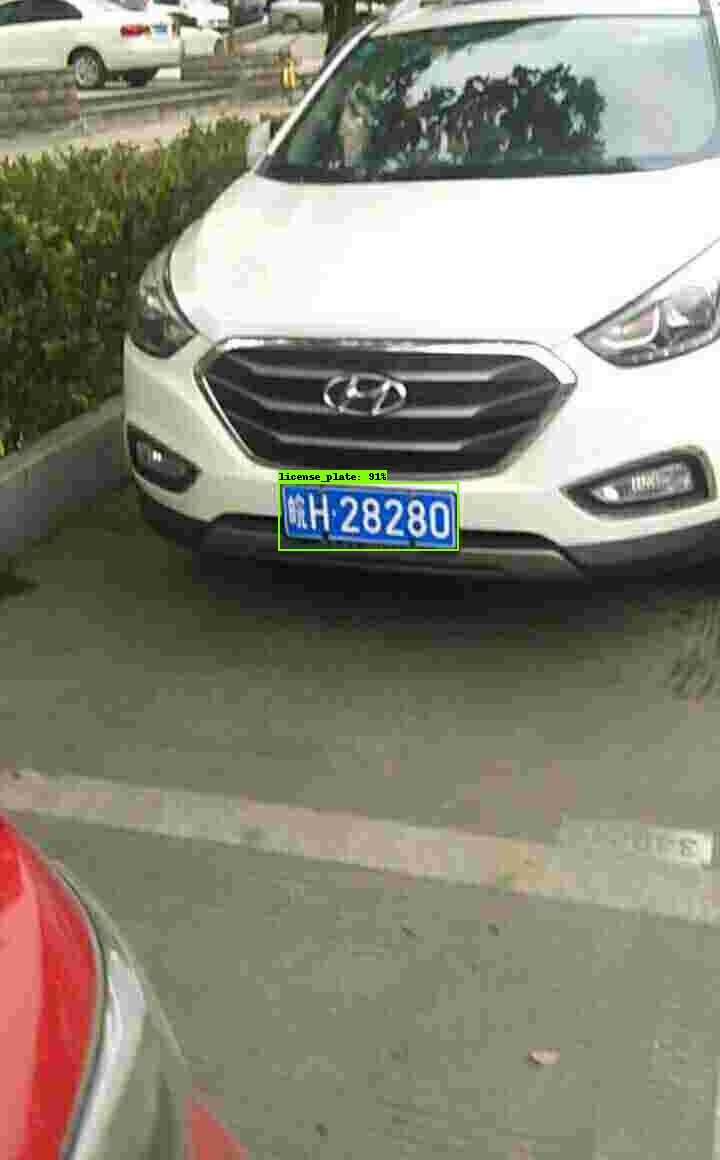

/content/AVLPR/results/12.jpg


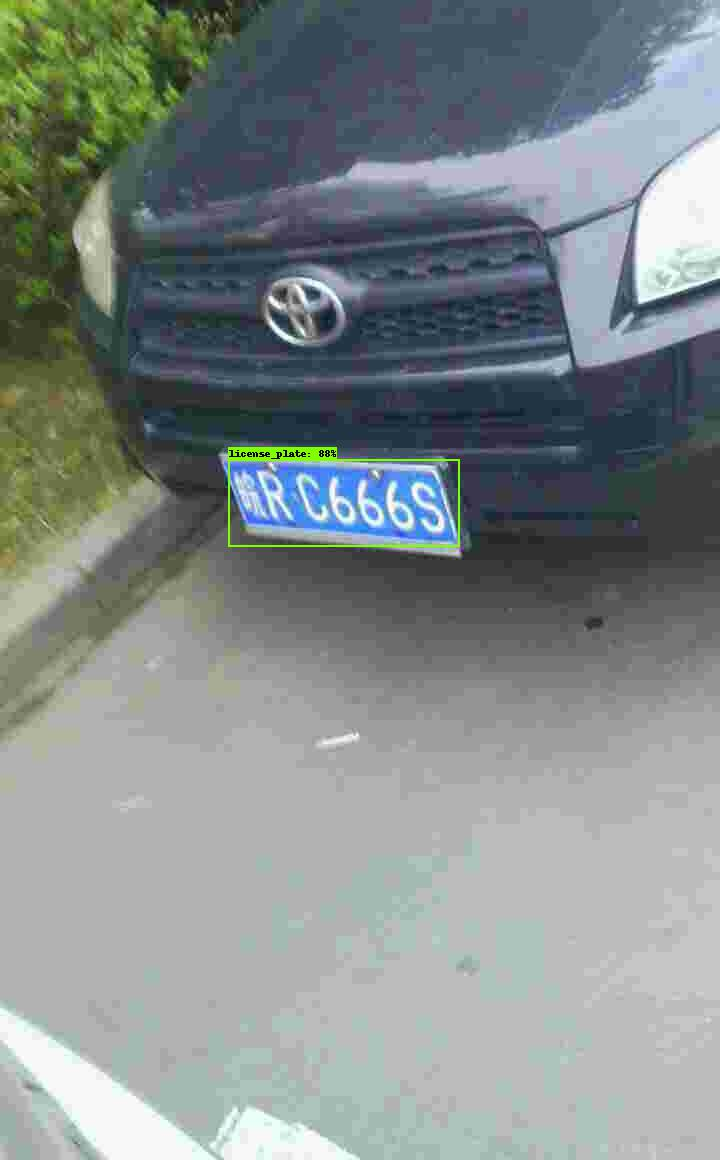

/content/AVLPR/results/13.jpg


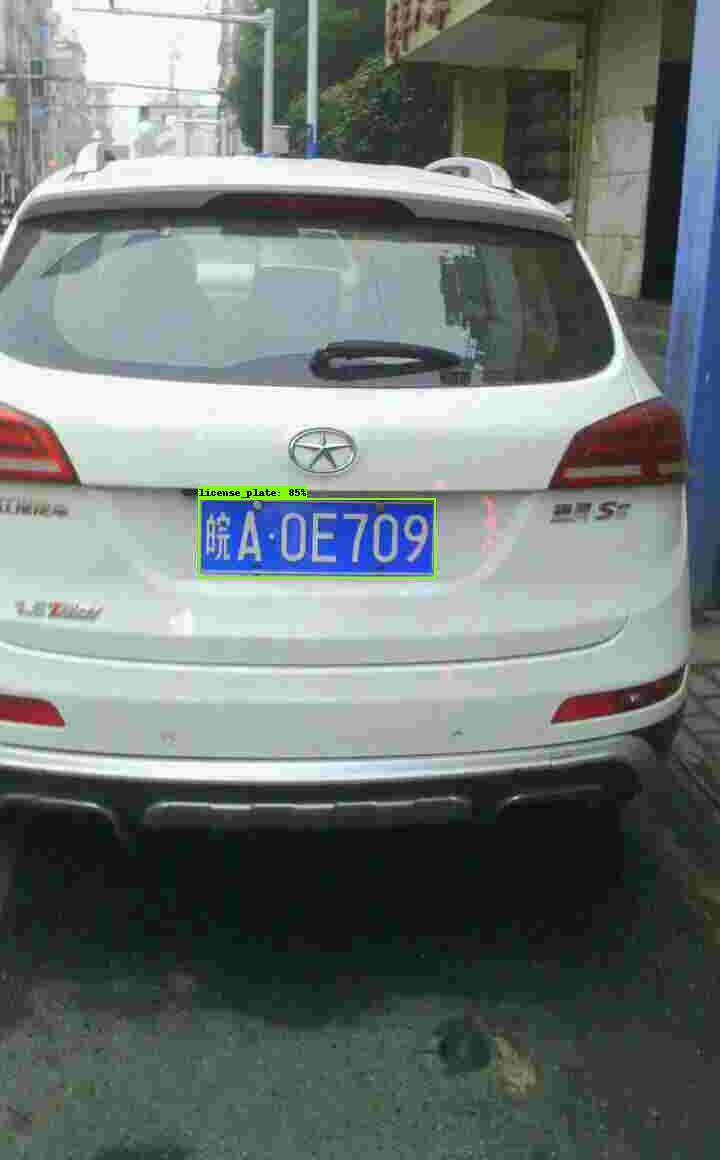

/content/AVLPR/results/14.jpg


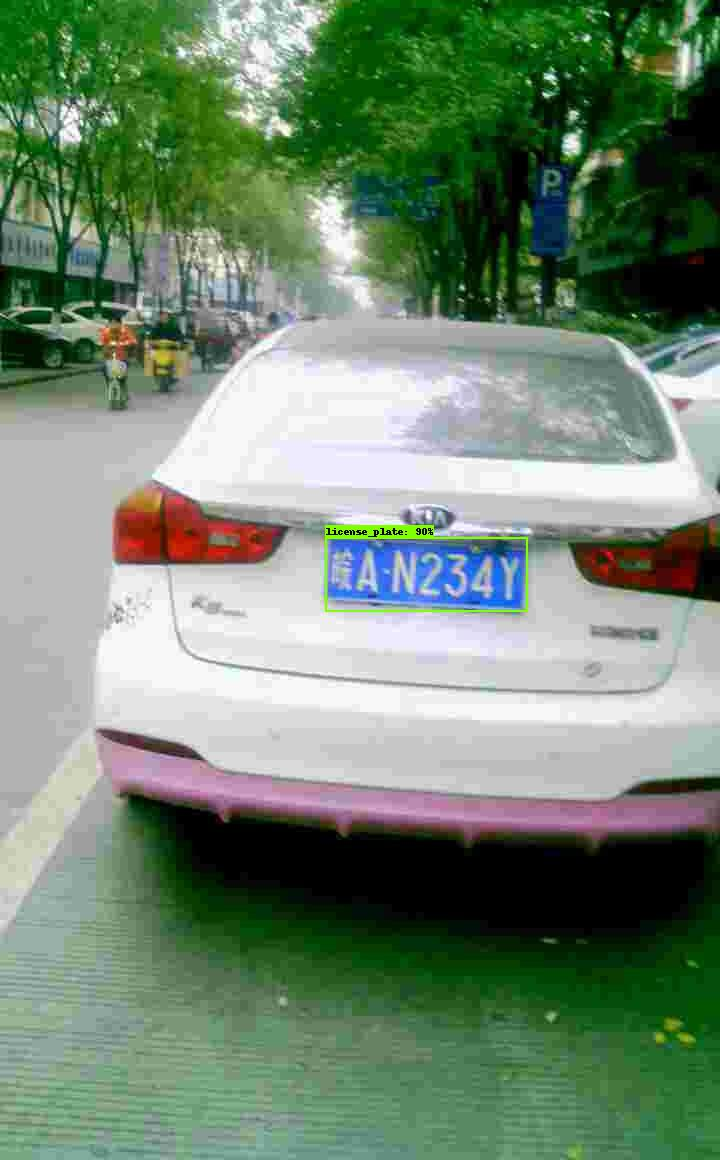

/content/AVLPR/results/15.jpg


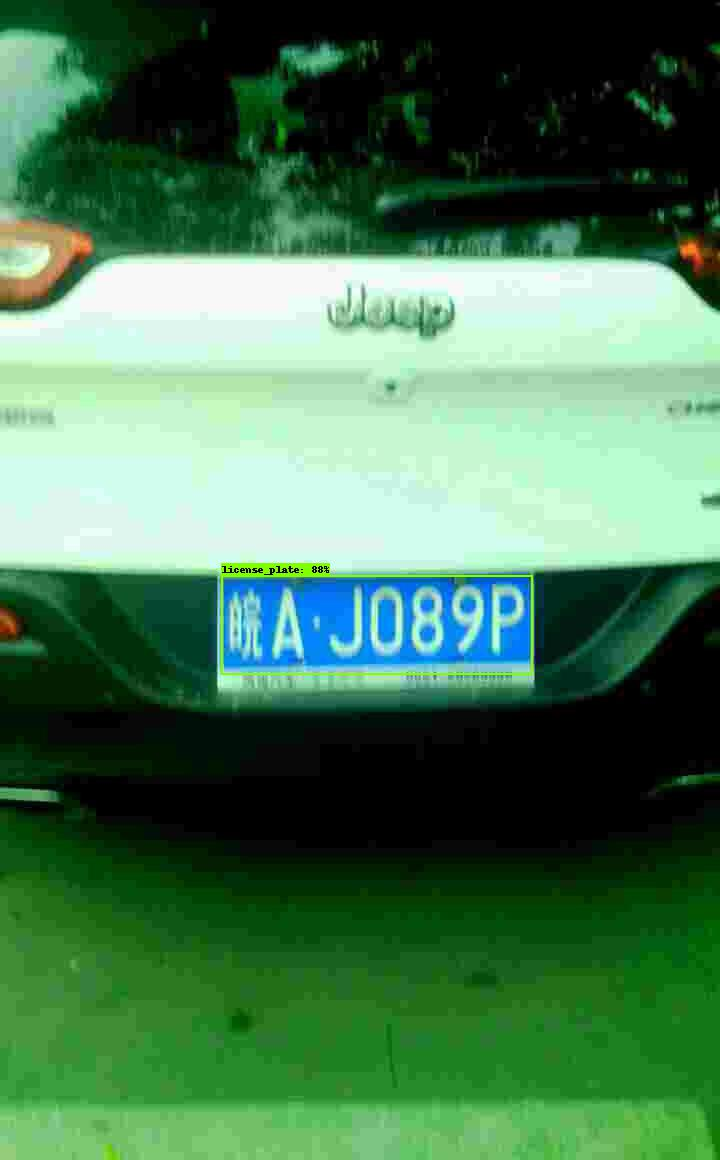

/content/AVLPR/results/16.jpg


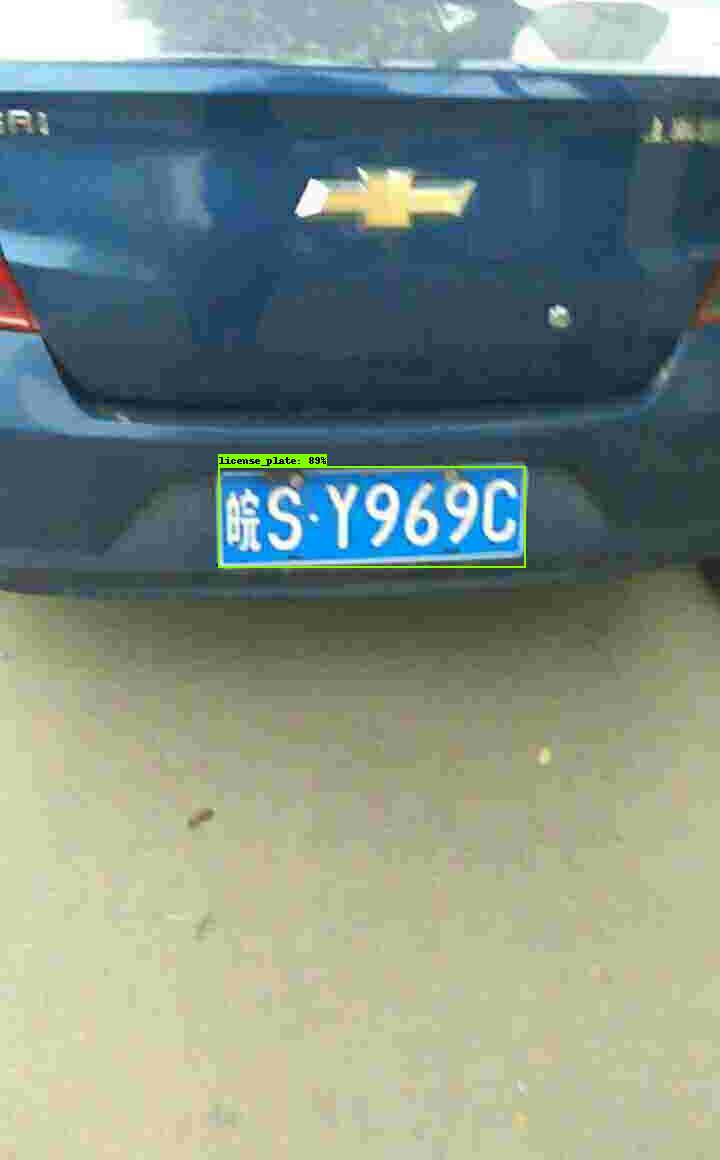

/content/AVLPR/results/17.jpg


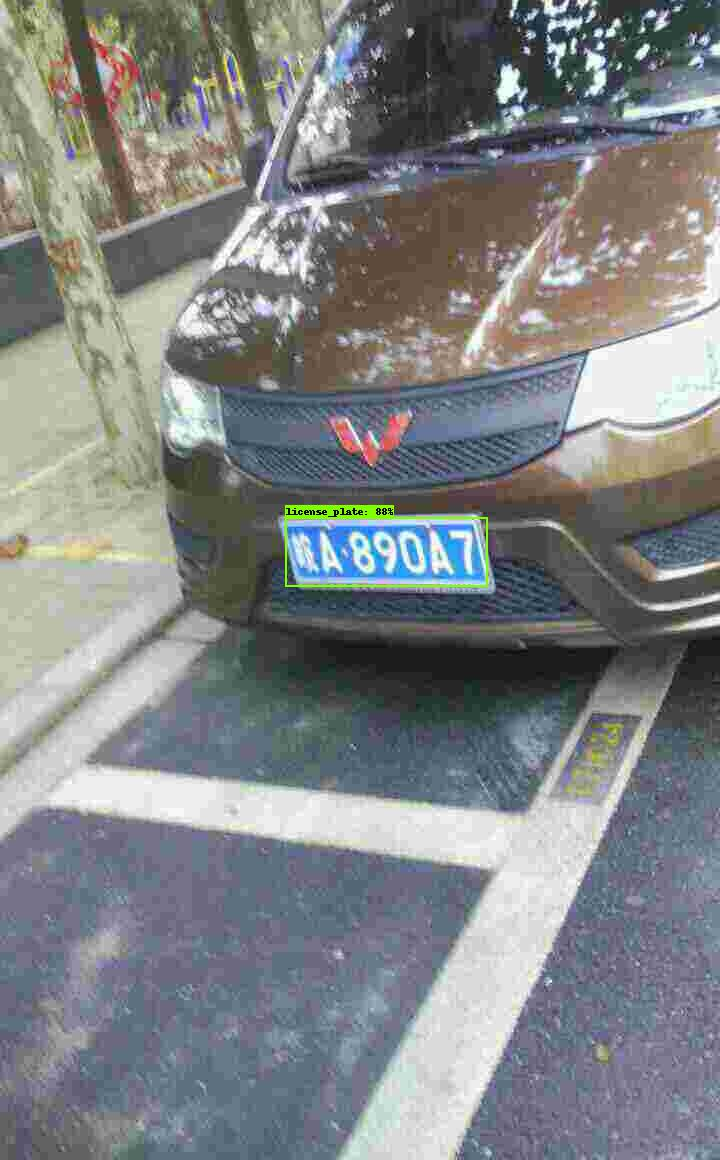

/content/AVLPR/results/18.jpg


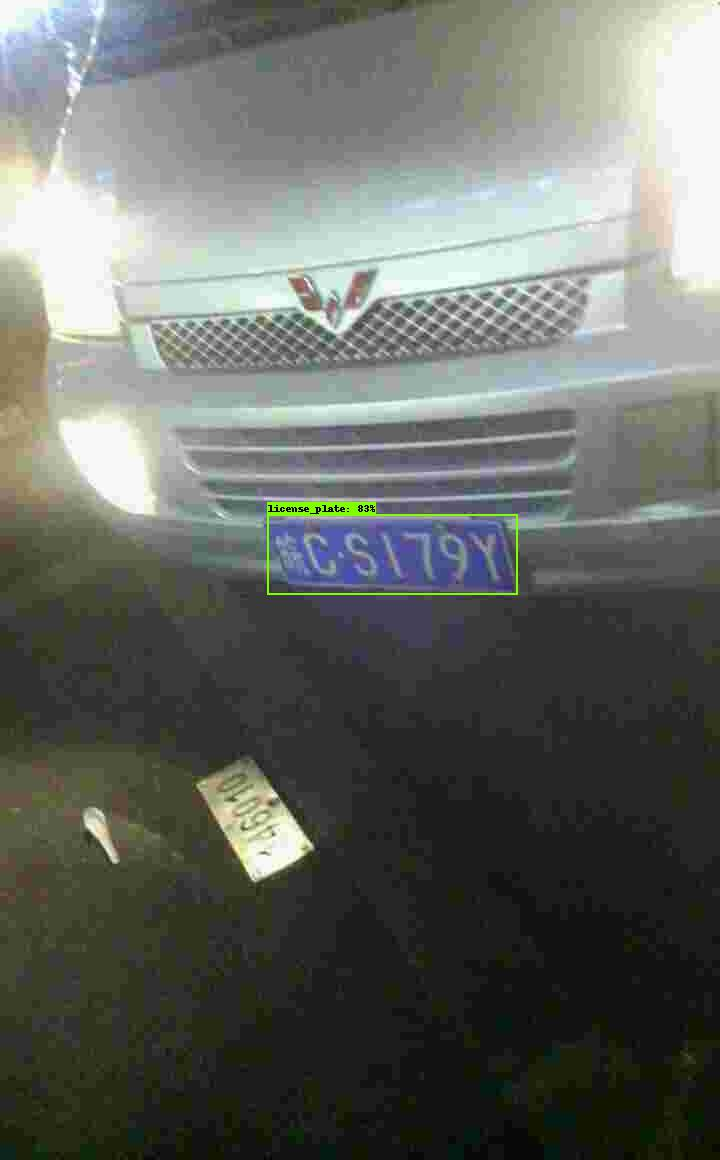

/content/AVLPR/results/19.jpg


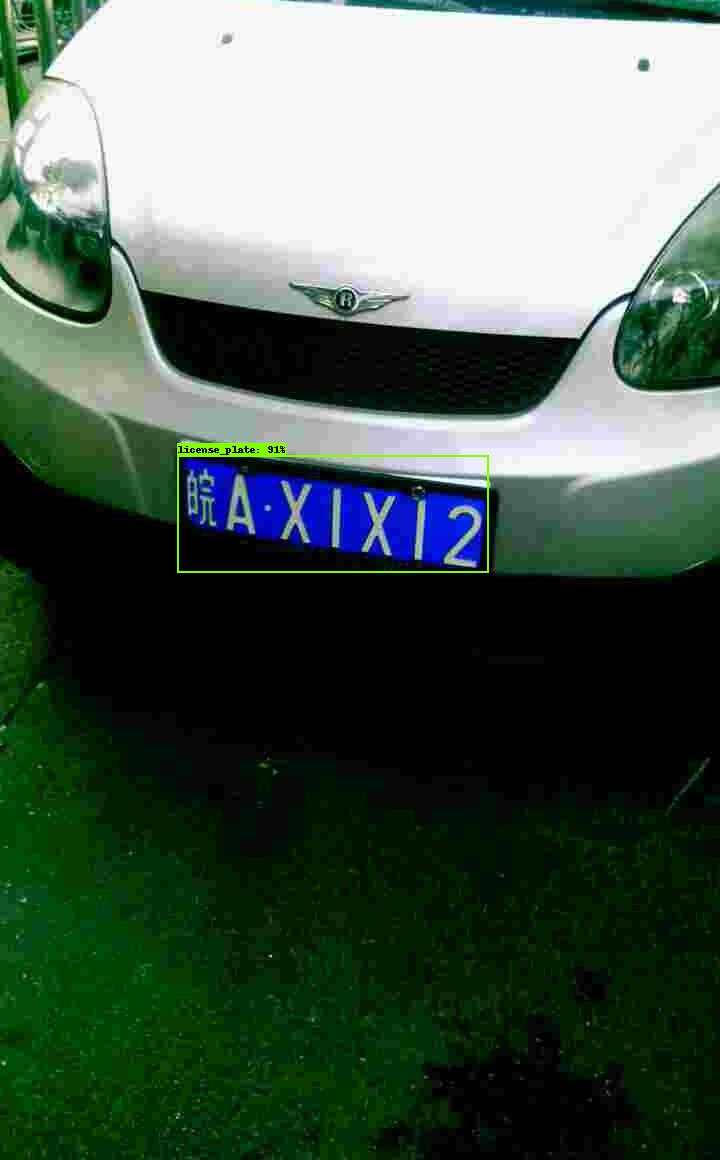

In [117]:
from IPython.display import Image, display

MAX_SHOW_RESULTS = 20

for i in range(MAX_SHOW_RESULTS):
    fname = os.path.join(RESULT_DIR, "{}.jpg".format(i))
    if os.path.exists(fname):
        print(fname)
        display(Image(fname))

## License Plate Number Recognition

In [28]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (27.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [121]:
import numpy as np
import cv2
from copy import deepcopy
from PIL import Image
import pytesseract as tess
from google.colab.patches import cv2_imshow

showing original image


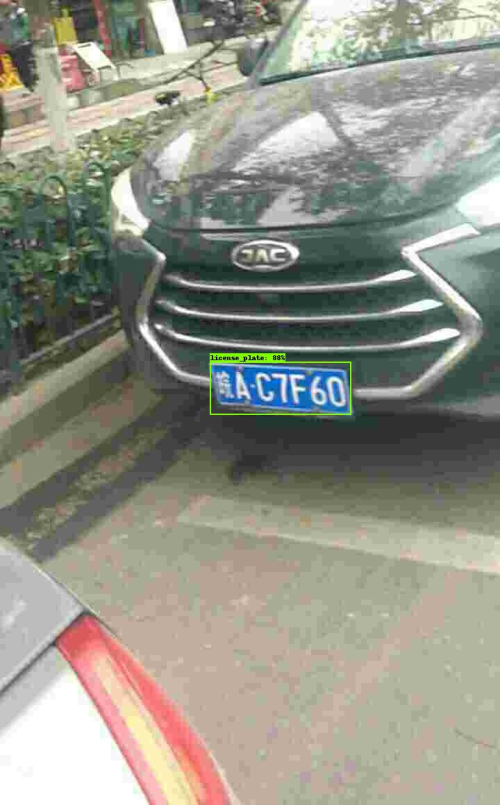

showing grayscale image


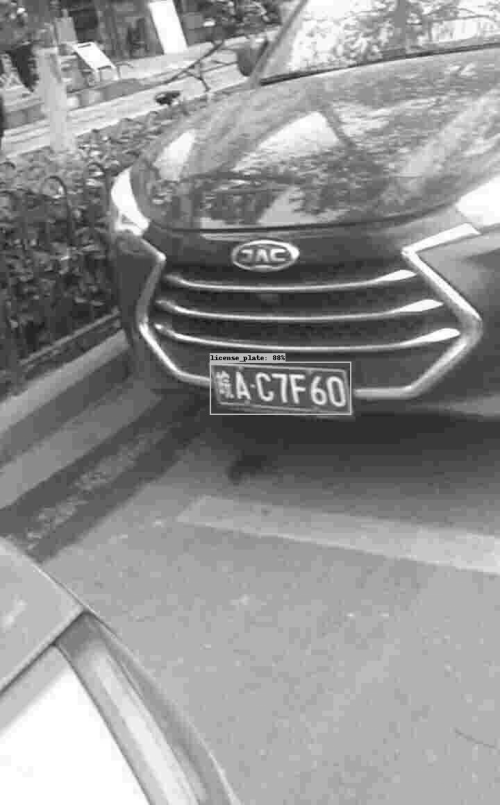

reducing noise in image


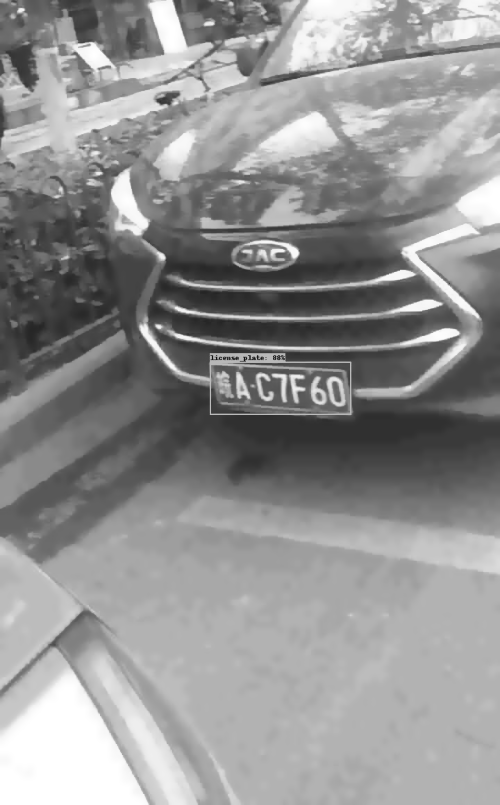

finding edge


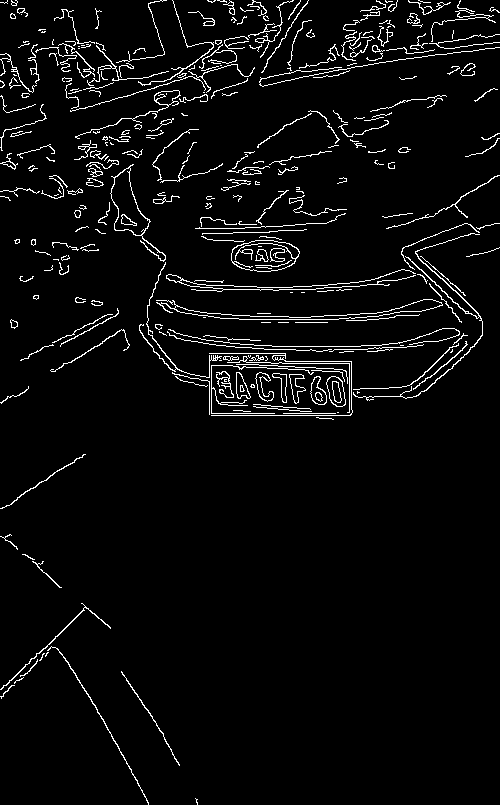

finding contours


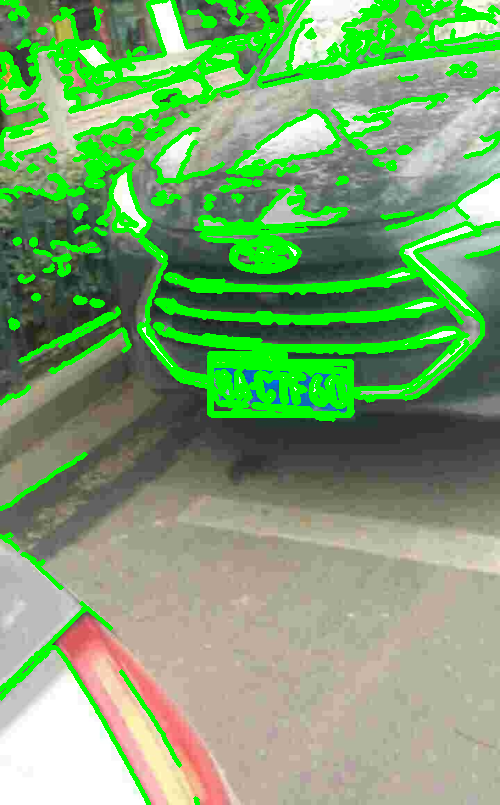

sorting top 30 contours


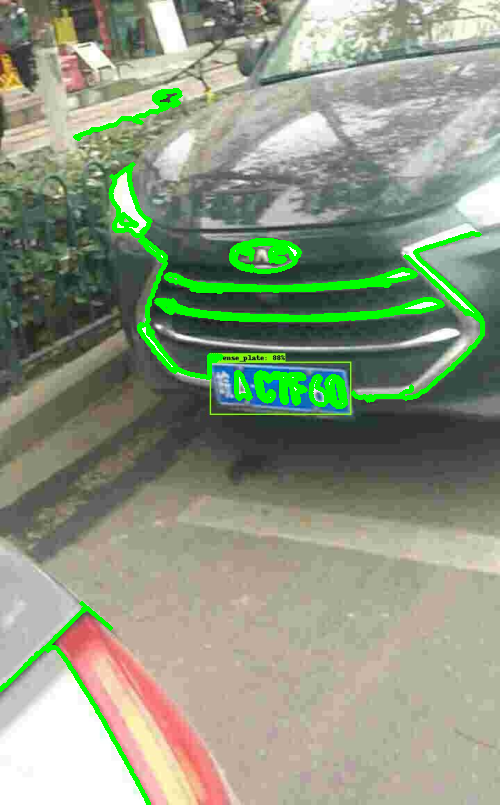

to find possibile number plate


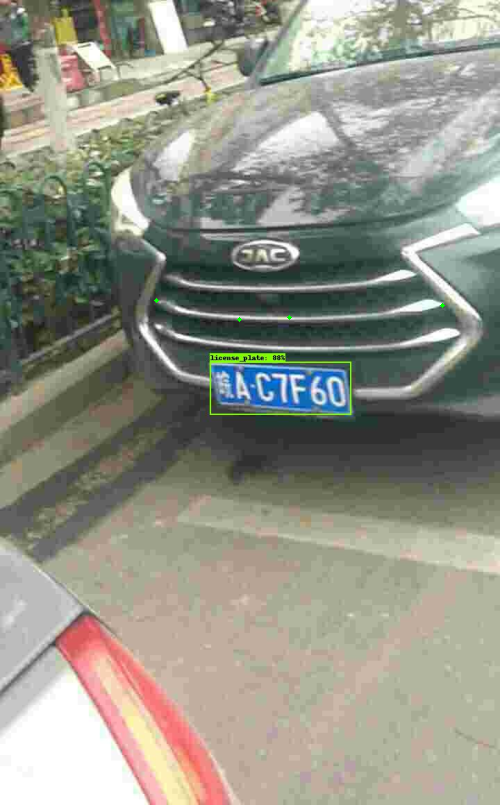

-1

In [168]:
#reading the img
import matplotlib.pyplot as plt
img =cv2.imread('/content/AVLPR/results/4.jpg')
#resizing and standardizing
img = imutils.resize(img,width=500)
print("showing original image")
cv2_imshow(img) #showing original image
cv2.waitKey(0)

#from rgb to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print("showing grayscale image")
cv2_imshow(gray)  #showing grayscale image
cv2.waitKey(0)

#reducing noise and making it smooth
gray = cv2.bilateralFilter(gray,11,17,17)
print("reducing noise in image")
cv2_imshow(gray)
cv2.waitKey(0)

#finding edge

edged =  cv2.Canny(gray,100,200)
print("finding edge")
cv2_imshow(edged)
cv2.waitKey(0)

#finding contours

cnts,new =cv2.findContours(edged.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

img1 =img.copy()
cv2.drawContours(img1,cnts,-1,(0,255,0),3)
print("finding contours")
cv2_imshow(img1)
cv2.waitKey(0)

#sorting top 30 contours
cnts = sorted(cnts,key=cv2.contourArea,reverse=True)[:30]

img2 =img.copy()
cv2.drawContours(img2,cnts,-1,(0,255,0),3)
print("sorting top 30 contours")
cv2_imshow(img2)
cv2.waitKey(0)

#to find possibile number plate
NumberPlateCount = None
count = 0
name = 1
for i in cnts:
    perimeter = cv2.arcLength(i,True)
    approx = cv2.approxPolyDP(i,0.018 * perimeter,True)
    if(len(approx)==4): #4 corners
        NumberPlateCount = approx
        x,y,w,h =cv2.boundingRect(i)
        crop = gray[y:y+h,x:x+w]
        cv2.imwrite('/content/AVLPR/Cropped_Images/' + str(name)+'.png',crop)
        name+=1
        break
cv2.drawContours(img,NumberPlateCount,-1,(0,255,0),3)
print("to find possibile number plate")
cv2_imshow(img)
cv2.waitKey(0)


In [ ]:
%cd /content/
import shutil
def main():
    # Copy file to another directory
    newPath = shutil.copytree('/content/AVLPR/results', '/content/drive/MyDrive/LicensePlate/AVLPR/results/')
    print("Path of copied file : ", newPath)
    
if __name__ == '__main__':
    main()

/content
